In [1]:
!ls /kaggle/input/hengck23-demo-submit-physionet/setup
!pip install connected-components-3d --no-index --find-links=file:///kaggle/input/hengck23-demo-submit-physionet/setup/

connected_components_3d-3.26.1-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl
numpy-2.3.4-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl
Looking in links: file:///kaggle/input/hengck23-demo-submit-physionet/setup/
Processing /kaggle/input/hengck23-demo-submit-physionet/setup/connected_components_3d-3.26.1-cp311-cp311-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl


In [2]:
import cc3d
import cv2
import pandas as pd
import numpy as np
from scipy import signal
import torch
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
import shutil
import copy
import multiprocessing as mp
import pickle
import os

import sys
sys.path.append('/kaggle/input/hengck23-demo-submit-physionet')

print('import ok!!!')

import ok!!!


In [3]:
FLOAT_TYPE = torch.float16 #torch.bfloat16

KAGGLE_DIR = \
	'/kaggle/input/physionet-ecg-image-digitization'
WEIGHT_DIR = \
	'/kaggle/input/hengck23-demo-submit-physionet/weight'
OUT_DIR = \
    f'/kaggle/working/outputs'
    
#--------------------------------------

def read_image(sample_id):
    image_id = sample_id
    image = cv2.imread(f'{KAGGLE_DIR}/test/{image_id}.png', cv2.IMREAD_COLOR_RGB)
    return image

def read_sampling_length(sample_id):
    image_id = sample_id
    d = valid_df[
        (valid_df['id']==image_id) & (valid_df['lead']=='II')
    ].iloc[0]
    length = d.number_of_rows
    return length

valid_df = pd.read_csv(f'{KAGGLE_DIR}/test.csv')
valid_df['id']=valid_df['id'].astype(str) 
valid_id = valid_df['id'].unique().tolist()

#valid_id = valid_id[:300]
print('valid_id:', len(valid_id))
print('\t', valid_id[:3], '...')
print('setting ok!!!\n')

valid_id: 2
	 ['1053922973', '2352854581'] ...
setting ok!!!



# Stage0

*** STARTING STAGE0 ***


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

THIS_DIR: /kaggle/input/hengck23-demo-submit-physionet
REF_PT: (9, 2)
*** STARTING STAGE0 (2GPU PARALLEL) ***
GPU0: 1 samples
GPU1: 1 samples
<All keys matched successfully>
<All keys matched successfully>
	 [GPU0]    0/1 1053922973   0 min 00 sec 0 min 00 sec
[GPU1] Stage0 completed. Failed: 0

demo results for stage0--------------
1053922973


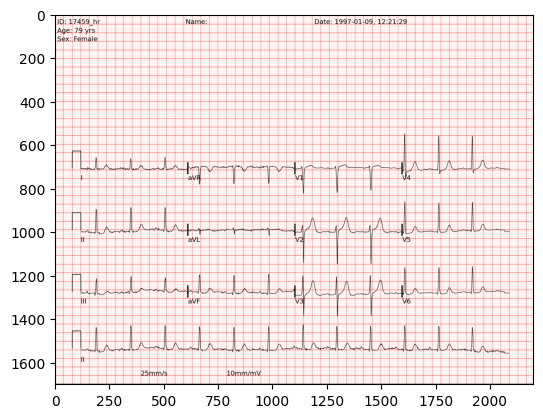

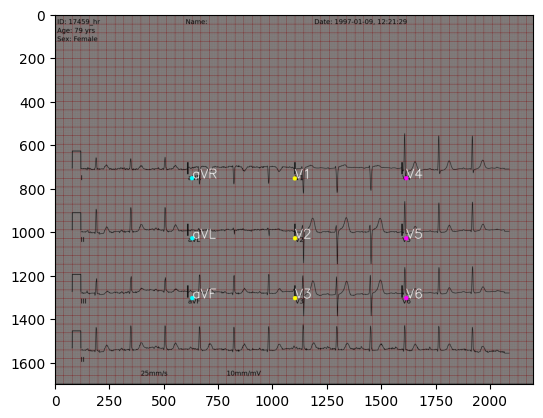

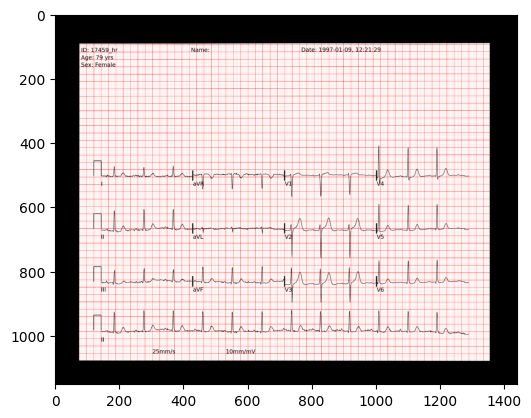


[GPU0] Stage0 completed. Failed: 0
FAIL_ID (Stage0): []
run_stage0_parallel() ok!!!



In [4]:
# stage0
print('*** STARTING STAGE0 ***')

from stage0_model import Net as Stage0Net
from stage0_common import *

os.makedirs(f'{OUT_DIR}/normalised', exist_ok=True)

def run_stage0(gpu_id=0, assigned_ids=None, fail_id_file=None):
	device = f'cuda:{gpu_id}'
	
	if assigned_ids is None:
		assigned_ids = valid_id
	
	local_fail_id = []
	
	stage0_net = Stage0Net(pretrained=False)
	stage0_net = load_net(stage0_net, f'{WEIGHT_DIR}/stage0-last.checkpoint.pth')
	stage0_net.to(device)

	start_timer = timer()
	for n, sample_id in enumerate(assigned_ids):
		timestamp = time_to_str(timer() - start_timer, 'sec')
		print(f'\r\t [GPU{gpu_id}] {n:4d}/{len(assigned_ids)} {sample_id}', timestamp, end='', flush=True)

		image = read_image(sample_id)
		batch = image_to_batch(image)

		with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
			with torch.no_grad():
				output = stage0_net(batch)

				try:
					rotated, keypoint = output_to_predict(image, batch, output)
					normalised, keypoint, homo = normalise_by_homography(rotated, keypoint)
					# ---
					cv2.imwrite(f'{OUT_DIR}/normalised/{sample_id}.norm.png', cv2.cvtColor(normalised, cv2.COLOR_RGB2BGR))
					np.save(f'{OUT_DIR}/normalised/{sample_id}.homo.npy', homo)
				except:
					local_fail_id.append(sample_id)

		torch.cuda.empty_cache()
		
		# Visualization only on GPU0
		if n<10 and gpu_id==0:
			overlay = draw_results_stage0(rotated, keypoint)
			print('')
			print('demo results for stage0--------------')
			print(sample_id)
			plt.imshow(image);plt.show()
			plt.imshow(overlay);plt.show()
			plt.imshow(normalised);plt.show()
			
	print(f'\n[GPU{gpu_id}] Stage0 completed. Failed: {len(local_fail_id)}')
	
	# Save FAIL_ID
	if fail_id_file:
		with open(fail_id_file, 'wb') as f:
			pickle.dump(local_fail_id, f)
	
	return local_fail_id


def run_stage0_parallel():
	"""Run Stage0 in parallel on 2 GPUs"""
	print('*** STARTING STAGE0 (2GPU PARALLEL) ***')
	
	# Split valid_id into 2 parts
	mid_idx = len(valid_id) // 2
	ids_gpu0 = valid_id[:mid_idx]
	ids_gpu1 = valid_id[mid_idx:]
	
	print(f'GPU0: {len(ids_gpu0)} samples')
	print(f'GPU1: {len(ids_gpu1)} samples')
	
	# FAIL_ID file paths
	fail_file_0 = f'{OUT_DIR}/fail_stage0_gpu0.pkl'
	fail_file_1 = f'{OUT_DIR}/fail_stage0_gpu1.pkl'
	
	# Run in parallel with 2 processes
	p0 = mp.Process(target=run_stage0, args=(0, ids_gpu0, fail_file_0))
	p1 = mp.Process(target=run_stage0, args=(1, ids_gpu1, fail_file_1))
	
	p0.start()
	p1.start()
	
	p0.join()
	p1.join()
	
	# Merge FAIL_IDs
	fail_id = []
	if os.path.exists(fail_file_0):
		with open(fail_file_0, 'rb') as f:
			fail_id.extend(pickle.load(f))
	if os.path.exists(fail_file_1):
		with open(fail_file_1, 'rb') as f:
			fail_id.extend(pickle.load(f))
	
	print(f'FAIL_ID (Stage0): {fail_id}')
	print('run_stage0_parallel() ok!!!\n')
	
	return fail_id


# Run (using parallel version)
FAIL_ID_STAGE0 = run_stage0_parallel()

# Stage1

*** STARTING STAGE1 ***
/kaggle/input/hengck23-demo-submit-physionet
*** STARTING STAGE1 (2GPU PARALLEL) ***
GPU0: 1 samples
GPU1: 1 samples
<All keys matched successfully>
<All keys matched successfully>
	 [GPU0]    0/1 1053922973  0 min 00 sec
[GPU1] Stage1 completed. Failed: 0

demo results for stage1--------------
1053922973


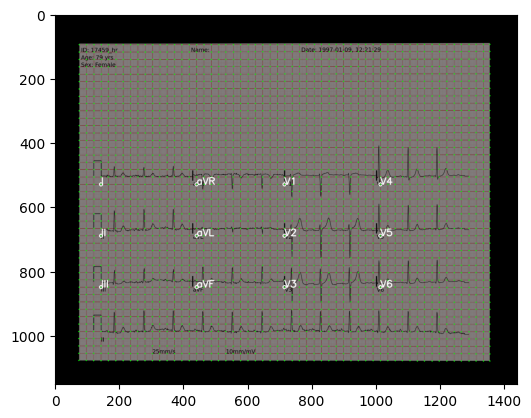

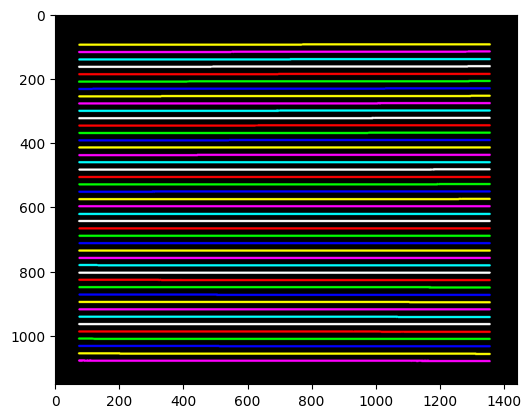

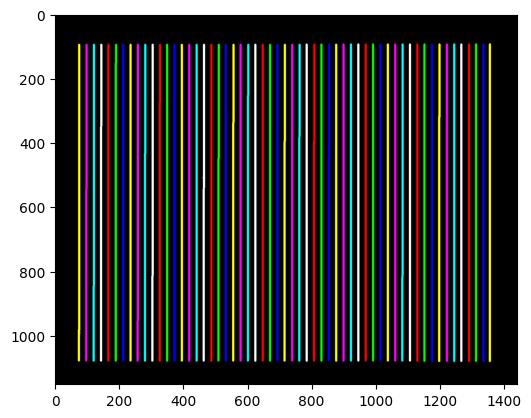

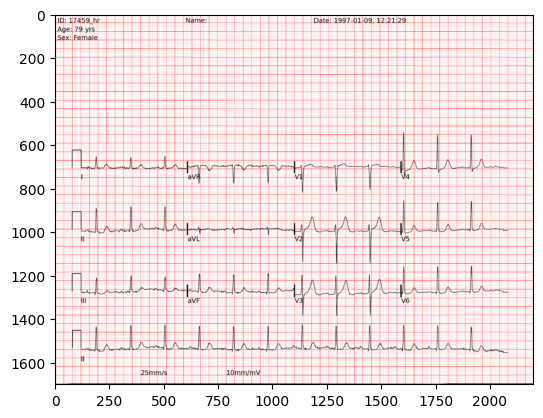


[GPU0] Stage1 completed. Failed: 0
FAIL_ID (Stage1): []
run_stage1_parallel() ok!!!



In [5]:
# stage1
print('*** STARTING STAGE1 ***')

from stage1_model import Net as Stage1Net
from stage1_common import *

os.makedirs(f'{OUT_DIR}/rectified', exist_ok=True)

def run_stage1(gpu_id=0, assigned_ids=None, prev_fail_ids=None, fail_id_file=None):
	"""
	Stage1 processing (GPU parallelization supported)
	
	Args:
		gpu_id: GPU number to use (0 or 1)
		assigned_ids: List of sample_ids to process (if None, use all valid_id)
		prev_fail_ids: IDs that failed in Stage0 (to be skipped)
		fail_id_file: File path to save FAIL_ID
	"""
	# GPU configuration
	device = f'cuda:{gpu_id}'
	
	# Determine processing targets
	if assigned_ids is None:
		assigned_ids = valid_id
	if prev_fail_ids is None:
		prev_fail_ids = []
	
	# Local FAIL_ID
	local_fail_id = []
	
	stage1_net = Stage1Net(pretrained=False)
	stage1_net = load_net(stage1_net, f'{WEIGHT_DIR}/stage1-last.checkpoint.pth')
	stage1_net.to(device)

	start_timer = timer()
	for n, sample_id in enumerate(assigned_ids):
		timestamp = time_to_str(timer() - start_timer, 'sec')
		print(f'\r\t [GPU{gpu_id}] {n:4d}/{len(assigned_ids)} {sample_id}', timestamp, end='', flush=True)
		
		# Skip IDs that failed in Stage0
		if sample_id in prev_fail_ids:
			continue

		image = cv2.imread(f'{OUT_DIR}/normalised/{sample_id}.norm.png', cv2.IMREAD_COLOR_RGB)
		batch = {
			'image': torch.from_numpy(np.ascontiguousarray(image.transpose(2, 0, 1))).unsqueeze(0),
		}
		num_tta = 1

		with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
			with torch.no_grad():
				output = stage1_net(batch)

				try:
					gridpoint_xy, more = output_to_predict(image, batch, output)
					rectified = rectify_image(image, gridpoint_xy)
					# ---
					cv2.imwrite(f'{OUT_DIR}/rectified/{sample_id}.rect.png', cv2.cvtColor(rectified, cv2.COLOR_RGB2BGR))
					np.save(f'{OUT_DIR}/rectified/{sample_id}.gridpoint_xy.npy',gridpoint_xy)
				except:
					local_fail_id.append(sample_id)

		torch.cuda.empty_cache()
		
		# Visualization only on GPU0
		if n<10 and gpu_id==0:
			overlay = draw_mapping(image, gridpoint_xy)
			ghfiltered, gvfiltered = draw_results_stage1(more)
			
			print('')
			print('demo results for stage1--------------')
			print(sample_id)
			plt.imshow(overlay);plt.show()
			plt.imshow(gvfiltered);plt.show()
			plt.imshow(ghfiltered);plt.show()
			plt.imshow(rectified);plt.show()
             
	print(f'\n[GPU{gpu_id}] Stage1 completed. Failed: {len(local_fail_id)}')
	
	# Save FAIL_ID
	if fail_id_file:
		with open(fail_id_file, 'wb') as f:
			pickle.dump(local_fail_id, f)
	
	return local_fail_id


def run_stage1_parallel(prev_fail_ids=None):
	"""Run Stage1 in parallel on 2 GPUs"""
	print('*** STARTING STAGE1 (2GPU PARALLEL) ***')
	
	# Split valid_id into 2 parts
	mid_idx = len(valid_id) // 2
	ids_gpu0 = valid_id[:mid_idx]
	ids_gpu1 = valid_id[mid_idx:]
	
	print(f'GPU0: {len(ids_gpu0)} samples')
	print(f'GPU1: {len(ids_gpu1)} samples')
	
	# FAIL_ID file paths
	fail_file_0 = f'{OUT_DIR}/fail_stage1_gpu0.pkl'
	fail_file_1 = f'{OUT_DIR}/fail_stage1_gpu1.pkl'
	
	# Run in parallel with 2 processes
	p0 = mp.Process(target=run_stage1, args=(0, ids_gpu0, prev_fail_ids, fail_file_0))
	p1 = mp.Process(target=run_stage1, args=(1, ids_gpu1, prev_fail_ids, fail_file_1))
	
	p0.start()
	p1.start()
	
	p0.join()
	p1.join()
	
	# Merge FAIL_IDs
	fail_id = []
	if os.path.exists(fail_file_0):
		with open(fail_file_0, 'rb') as f:
			fail_id.extend(pickle.load(f))
	if os.path.exists(fail_file_1):
		with open(fail_file_1, 'rb') as f:
			fail_id.extend(pickle.load(f))
	
	# Include Stage0 failed IDs as well
	if prev_fail_ids:
		fail_id.extend(prev_fail_ids)
	
	print(f'FAIL_ID (Stage1): {fail_id}')
	print('run_stage1_parallel() ok!!!\n')
	
	return fail_id


# Run (using parallel version)
FAIL_ID_STAGE1 = run_stage1_parallel(prev_fail_ids=FAIL_ID_STAGE0)

# Stage2

In [6]:
def pixel_to_series_exp(pixel, zero_mv, length):
    _, H, W = pixel.shape
    eps=1e-8
    y_idx = np.arange(H, dtype=np.float32)[:, None]  # (H, 1) for broadcasting
    
    series = []
    for j in [0, 1, 2, 3]:
        p = pixel[j]
        denom = p.sum(axis=0)  # (W,)
        y_exp = (p * y_idx).sum(axis=0) / (denom + eps)  # (W,)
        
        series.append(y_exp)
    series = np.stack(series).astype(np.float32)

    if length is not None:
        if length!=W:
            resampled_series = []
            for s in series:
                rs = signal.resample(s, length).astype(np.float32)
                resampled_series.append(rs)
            series = np.stack(resampled_series)

    return series

In [7]:
def get_whole_model(encoder_name, weight_path, device):
    stage2_model = WholeModel(
        encoder_name=encoder_name,
        encoder_weights=None,
        decoder_name="unet",
        use_coord_conv=True,
        pretrained=False
    )
    state_dict = torch.load(weight_path, map_location=lambda storage, loc: storage)
    print(stage2_model.load_state_dict(state_dict, strict=False))
    stage2_model.to(device)
    stage2_model.eval()
    stage2_model.output_type = ['infer']
    return stage2_model

In [8]:
def get_lead_model(encoder_name, weight_path, fusion_type, device):
    stage2_model = LeadModel(
        encoder_name=encoder_name,
        encoder_weights=None,
        fusion_type=fusion_type,
    )
    state_dict = torch.load(weight_path, map_location=lambda storage, loc: storage)
    print(stage2_model.load_state_dict(state_dict, strict=False))
    stage2_model.to(device)
    stage2_model.eval()
    stage2_model.output_type = ['infer']
    return stage2_model

In [9]:
def read_images(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_W, IMG_H),interpolation=cv2.INTER_LINEAR)
    trim_image = image.copy()[OFFSET:y1, x0:x1]

    # Make lead images
    image = image[y0:y1, x0:x1]
    H, W, _ = image.shape
    lead_images = []

    for i, zmv in enumerate(zero_mv):
        # Crop within zero_mv +- WINDOW_SIZE range (pad with black for out-of-bounds areas)
        h0, h1 = int(zmv) - WINDOW_SIZE, int(zmv) + WINDOW_SIZE
        src_h0 = max(0, h0)
        src_h1 = min(H, h1)
        dst_h0 = src_h0 - h0
        dst_h1 = dst_h0 + (src_h1 - src_h0)
        
        lead_img = np.zeros((WINDOW_SIZE*2, W, 3))
        lead_img[dst_h0:dst_h1, :, :] = image[src_h0:src_h1, :, :]
        lead_images.append(lead_img)

    lead_images = np.stack(lead_images) # (4, H, W, 3)
    return trim_image, lead_images

In [10]:
WINDOW_SIZE = 240
OFFSET = 416
IGNORE_EDGE = 8
x_scale = 5000/(2080-118)
add_x = 1
y_scale = 1
IMG_H, IMG_W = int(1700*y_scale), int(2200*x_scale)+add_x

tta = [0, 2]

x0, x1 = 0, 5600
y0, y1 = 0, 1696
print(x0, x1)
print(y0, y1)
zero_mv = [ 703.5, 987.5, 1271.5, 1531.5 ]
zero_mv_trimed = [pos - OFFSET for pos in zero_mv]
zero_mv_croped = [WINDOW_SIZE + 0.5 for _ in range(4)]
mv_to_pixel = 79.0
t0,t1 = timespan = int(118*x_scale)+add_x, int(2080*x_scale)+add_x

0 5600
0 1696


In [11]:
height_after_trimed = y1 - OFFSET
print("height_after_trimed :", height_after_trimed)
ens_regions = []
for zmv in zero_mv_trimed:
    trim_upper = int(zmv) - WINDOW_SIZE
    trim_lower = int(zmv) + WINDOW_SIZE

    # Do not use the top and bottom IGNORE_EDGE pixels of lead prediction for ensemble
    lead_upper = IGNORE_EDGE
    lead_lower = -IGNORE_EDGE
    if trim_lower > height_after_trimed:
        print(trim_lower)
        # (black padding area + edge) * -1
        lead_lower = (trim_lower - height_after_trimed + IGNORE_EDGE) * -1
        trim_lower = height_after_trimed

    trim_upper += IGNORE_EDGE
    trim_lower -= IGNORE_EDGE
    ens_regions.append([trim_upper, trim_lower, lead_upper, lead_lower])
ens_regions

height_after_trimed : 1280
1355


[[55, 519, 8, -8], [339, 803, 8, -8], [623, 1087, 8, -8], [883, 1272, 8, -83]]

In [12]:
pip install --no-deps segmentation-models-pytorch==0.5.0

Note: you may need to restart the kernel to use updated packages.


*** STARTING STAGE2 ***
/kaggle/input/hengck23-demo-submit-physionet
*** STARTING STAGE2 (2GPU PARALLEL) ***
GPU0: 1 samples
GPU1: 1 samples
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully><All keys matched successfully>

<All keys matched successfully><All keys matched successfully>

<All keys matched successfully><All keys matched successfully>

<All keys matched successfully>
<All keys matched successfully>
	    0 1053922973  0 min 00 sec
check max intensity :  0.9973549743493398

	    1 2352854581  0 min 13 sec

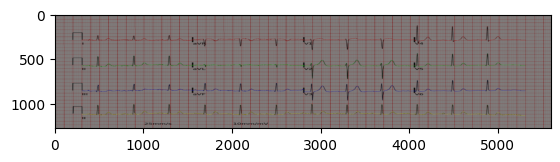

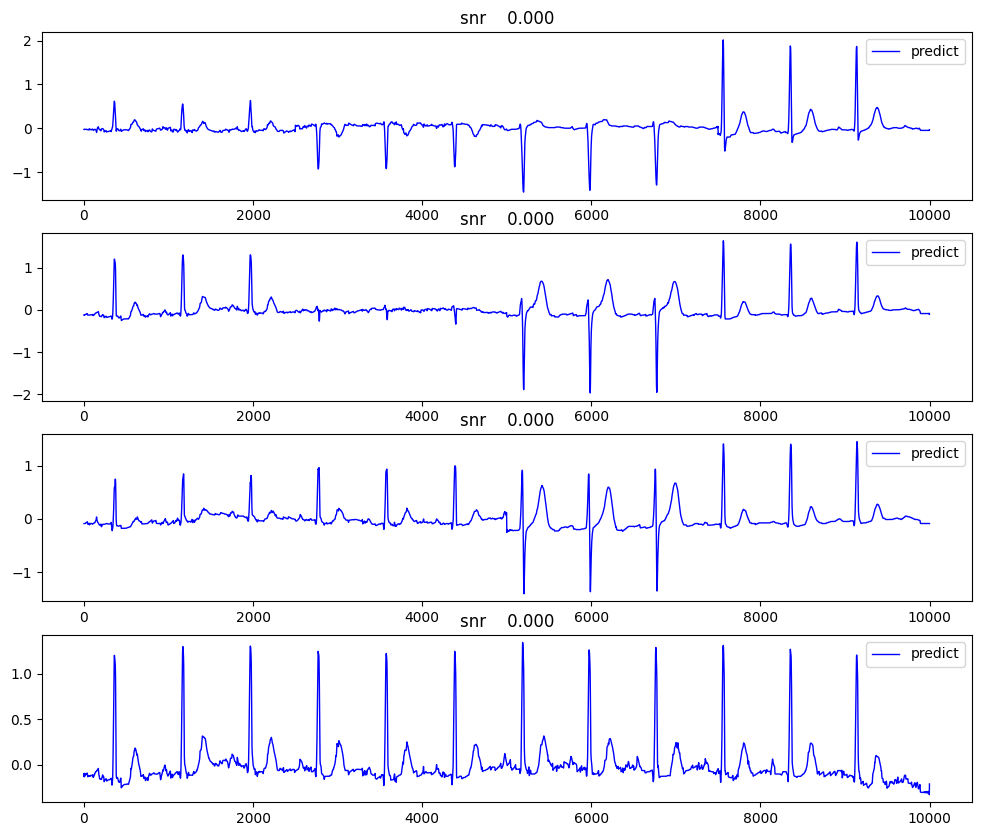

	    1 2352854581  0 min 15 sec

[GPU1] Stage2 completed. Failed: 0

check max intensity :  0.9974200477202734



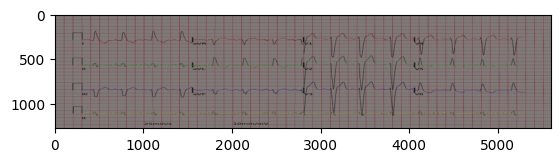

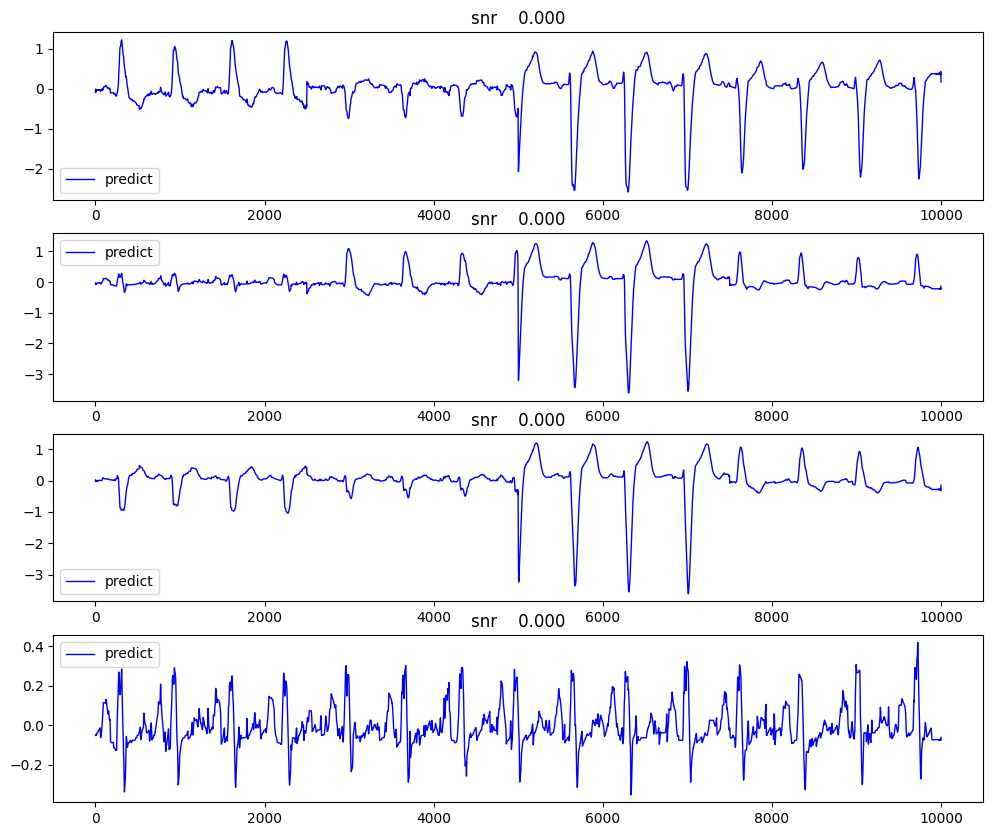



[GPU0] Stage2 completed. Failed: 0
FAIL_ID (Stage2): []
run_stage2_parallel() ok!!!



In [13]:
# stage2
print('*** STARTING STAGE2 ***')

sys.path.append("/kaggle/input/physionet-final-submission-models")
import torch.nn as nn
from stage2_smp_model import Net as WholeModel
from stage2_lead_model import Net as LeadModel
from stage2_model import prob_to_series_by_max
from stage2_common import *

os.makedirs(f'{OUT_DIR}/digitalised', exist_ok=True)
#os.makedirs(f'{OUT_DIR}/debug', exist_ok=True)

def run_stage2(gpu_id=0, assigned_ids=None, prev_fail_ids=None, fail_id_file=None):
    """
    Stage2 processing (GPU parallelization supported)
    
    Args:
        gpu_id: GPU number to use (0 or 1)
        assigned_ids: List of sample_ids to process (if None, use all valid_id)
        prev_fail_ids: IDs that failed in Stage0/1 (to be skipped)
        fail_id_file: File path to save FAIL_ID
    """
    # GPU configuration
    device = f'cuda:{gpu_id}'
    
    # Determine processing targets
    if assigned_ids is None:
        assigned_ids = valid_id
    if prev_fail_ids is None:
        prev_fail_ids = []
    
    # Local FAIL_ID
    local_fail_id = []

    whole_models = [
        # b7, 22.93
        get_whole_model("tu-timm/tf_efficientnet_b7.ns_jft_in1k", "/kaggle/input/physionet-final-submission-models/whole_b7_lb22.93.pth", device),
        # v2-l, 22.60
        get_whole_model("tu-timm/tf_efficientnetv2_l.in21k", "/kaggle/input/physionet-final-submission-models/whole_v2_l_lb22.60.pth", device),
        # v2-m, 22.58
        #get_whole_model("tu-timm/tf_efficientnetv2_m.in21k_ft_in1k", "/kaggle/input/physionet-final-submission-models/whole_v2_m_lb22.58.pth", device),
        # v2-m, 22.52
        #get_whole_model("tu-timm/tf_efficientnetv2_m.in21k", "/kaggle/input/physionet-final-submission-models/whole_v2_m_lb22.52.pth", device),
    ]
    
    lead_models = [
        # b6-shared-conv2d, 23.10
        get_lead_model("tu-timm/tf_efficientnet_b6.ns_jft_in1k", "/kaggle/input/physionet-final-submission-models/series_b6_shared_conv2d_lb23.10.pth", "shared_conv2d", device),
        # b6-shared-conv2d, 23.00
        get_lead_model("tu-timm/tf_efficientnet_b6.ns_jft_in1k", "/kaggle/input/physionet-final-submission-models/series_b6_shared_conv2d_lb23.00.pth", "shared_conv2d", device),
        # b4-shared-conv2d, 22.93
        #get_lead_model("tu-timm/tf_efficientnet_b4.ns_jft_in1k", "/kaggle/input/physionet-final-submission-models/series_b4_shared_conv2d_lb22.93.pth", "shared_conv2d", device),
        # v2-l-3d, 22.92
        get_lead_model("tu-timm/tf_efficientnetv2_l.in21k", "/kaggle/input/physionet-final-submission-models/series_v2_l_conv3d_lb22.92.pth", "conv3d", device),
        # v2-m-3d, 22.73
        #get_lead_model("tu-timm/tf_efficientnetv2_m.in21k", "/kaggle/input/physionet-final-submission-models/series_v2_m_conv3d_lb22.73.pth", "conv3d", device),
        # v2-l-2d, 22.85
        get_lead_model("tu-timm/tf_efficientnetv2_l.in21k", "/kaggle/input/physionet-final-submission-models/series_v2_l_conv2d_lb22.85.pth", "conv2d", device),
        # v2-m-2d, 22.76
        #get_lead_model("tu-timm/tf_efficientnetv2_m.in21k", "/kaggle/input/physionet-final-submission-models/series_v2_m_conv2d_lb22.76.pth", "conv2d", device),

    ]
        
    start_timer = timer()
    for n, sample_id in enumerate(valid_id):    
        timestamp = time_to_str(timer() - start_timer, 'sec')
        print(f'\r\t {n:4d} {sample_id}', timestamp, end='', flush=True)
        if sample_id in prev_fail_ids: continue

        length = read_sampling_length(sample_id)
    
        trim_image, lead_images = read_images(f'{OUT_DIR}/rectified/{sample_id}.rect.png')

        
        pixel_ens = np.zeros((4, trim_image.shape[0], trim_image.shape[1])) * 1.0
        # Infer whole models
        
        batch = {
            'image': torch.from_numpy(np.ascontiguousarray(trim_image.transpose(2, 0, 1))).unsqueeze(0),
        }
        batch_tta = {
            'image': torch.from_numpy(np.ascontiguousarray(np.fliplr(trim_image).copy().transpose(2, 0, 1))).unsqueeze(0),
        }
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                for model in whole_models:
                    for flip in tta:
                        if flip:
                            output = model(batch_tta)
                            pixel = output['pixel'].float().data.cpu().numpy()[0]
                            pixel = np.flip(pixel, axis=flip)
                        else:
                            output = model(batch)
                            pixel = output['pixel'].float().data.cpu().numpy()[0]
                        pixel_ens += pixel

        # Infer lead models
        lead_images = torch.from_numpy(lead_images.transpose(0, 3, 1, 2)).contiguous() # (4, 3, H, W)
        batch = {
            'image': lead_images.unsqueeze(0),
        }
        batch_tta = {
            'image': torch.flip(lead_images, dims=[3]).unsqueeze(0),
        }
        with torch.amp.autocast('cuda', dtype=FLOAT_TYPE):
            with torch.no_grad():
                for model in lead_models:
                    for flip in tta:
                        if flip:
                            output = model(batch_tta)
                            pixel = output['pixel'].float().data.cpu().numpy()[0].squeeze(1)
                            pixel = np.flip(pixel, axis=flip)
                        else:
                            output = model(batch)
                            pixel = output['pixel'].float().data.cpu().numpy()[0].squeeze(1)
                        for i in range(4):
                            # Lead i
                            trim_upper, trim_lower, lead_upper, lead_lower = ens_regions[i]
                            
                            pixel_ens[i][trim_upper:trim_lower] += pixel[i][lead_upper:lead_lower]

        # Average per pixel
        # Weight for whole model (entire trimmed image)
        ens_weight = np.ones((trim_image.shape[0], trim_image.shape[1])) * len(whole_models) * len(tta)
        # Weight for lead model (lead regions only)
        for i in range(4):
            trim_upper, trim_lower, _, _ = ens_regions[i]
            ens_weight[trim_upper:trim_lower] += len(lead_models) * len(tta)

        pixel_ens /= ens_weight
        
    
        #---
        try:
        #if 1:
            series_in_pixel = pixel_to_series_exp(pixel_ens[..., t0:t1], zero_mv_trimed, length)
            series = (np.array(zero_mv_trimed).reshape(4, 1) - series_in_pixel) / mv_to_pixel
            #series = filter_series_by_limits_modified(series)
    
            # ---
            #cv2.imwrite(f'{OUT_DIR}/digitalised/{sample_id}.lead.png', cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            np.save(f'{OUT_DIR}/digitalised/{sample_id}.series.npy', series)
    
        except:
            local_fail_id.append(sample_id)
    
        if n<10 and gpu_id==0: # optional: show results
            print()
            print("check max intensity : ", np.max(pixel_ens))
            print()
            
            overlay = draw_lead_pixel(trim_image, pixel_ens)
            plt.imshow(overlay); plt.show()
    
            t = np.arange(len(series[0]))
            fig, axes = plt.subplots(4, 1, figsize=(12, 10))
            for j in range(4):
                snr=0
                axes[j].plot(t, series[j], alpha=1.0, color='blue', linewidth=1, label='predict')
                axes[j].set_title(f'snr {snr:8.3f}')
                axes[j].legend()
            plt.show()
    print('')
    print(f'\n[GPU{gpu_id}] Stage2 completed. Failed: {len(local_fail_id)}')
    
    # Save FAIL_ID
    if fail_id_file:
        with open(fail_id_file, 'wb') as f:
            pickle.dump(local_fail_id, f)
    
    return local_fail_id
    
def run_stage2_parallel(prev_fail_ids=None):
	"""Run Stage2 in parallel on 2 GPUs"""
	print('*** STARTING STAGE2 (2GPU PARALLEL) ***')
	
	# Split valid_id into 2 parts
	mid_idx = len(valid_id) // 2
	ids_gpu0 = valid_id[:mid_idx]
	ids_gpu1 = valid_id[mid_idx:]
	
	print(f'GPU0: {len(ids_gpu0)} samples')
	print(f'GPU1: {len(ids_gpu1)} samples')
	
	# FAIL_ID file paths
	fail_file_0 = f'{OUT_DIR}/fail_stage2_gpu0.pkl'
	fail_file_1 = f'{OUT_DIR}/fail_stage2_gpu1.pkl'
	
	# Run in parallel with 2 processes
	p0 = mp.Process(target=run_stage2, args=(0, ids_gpu0, prev_fail_ids, fail_file_0))
	p1 = mp.Process(target=run_stage2, args=(1, ids_gpu1, prev_fail_ids, fail_file_1))
	
	p0.start()
	p1.start()
	
	p0.join()
	p1.join()
	
	# Merge FAIL_IDs
	fail_id = []
	if os.path.exists(fail_file_0):
		with open(fail_file_0, 'rb') as f:
			fail_id.extend(pickle.load(f))
	if os.path.exists(fail_file_1):
		with open(fail_file_1, 'rb') as f:
			fail_id.extend(pickle.load(f))
	
	# Include Stage0/1 failed IDs as well
	if prev_fail_ids:
		fail_id.extend(prev_fail_ids)
	
	print(f'FAIL_ID (Stage2): {fail_id}')
	print('run_stage2_parallel() ok!!!\n')
	
	return fail_id


# Run (using parallel version)
FAIL_ID_STAGE2 = run_stage2_parallel(prev_fail_ids=FAIL_ID_STAGE1)

# Submission

In [14]:
#make sbmission csv
def make_submission():
	print('===========================================')
	print('making submission csv ...')

	submit_df=[]
	gb = valid_df.groupby('id')
	for i,(sample_id, df) in enumerate(gb): 
		try:
			series = np.load(f'{OUT_DIR}/digitalised/{sample_id}.series.npy')

			series_by_lead={}
			for l in range(3):
				lead = [
					['I',   'aVR', 'V1', 'V4'],
					['II',  'aVL', 'V2', 'V5'],
					['III', 'aVF', 'V3', 'V6'],
				][l]

				length=[
					df[df['lead']==lead[j]].iloc[0].number_of_rows
					for j in range(4)
				]
				if lead[0]=='II':
					length[0] = length[0]-sum(length[1:])

				index = np.cumsum(length)[:-1]
				split = np.split(series[l], index)
				for (k, s) in zip(lead, split):
					series_by_lead[k] = s
			series_by_lead['II'] = series[3]
    
		except: 
			series_by_lead = {}
			for j,d in df.iterrows():
				series_by_lead[d.lead] = np.zeros(d.number_of_rows)

		for j,d in df.iterrows():

			series_by_lead[d.lead] = np.concatenate([
                series_by_lead[d.lead], np.zeros_like(series_by_lead[d.lead])
            ])[:d.number_of_rows]
			assert(len(series_by_lead[d.lead])==d.number_of_rows) 
			print(f'\r\t {i} {sample_id} : {d.lead}', end='', flush=True)

			row_id = [
				f'{sample_id}_{i}_{d.lead}' for i in range(d.number_of_rows)
			]
			this_df = pd.DataFrame({
				'id':row_id,
				'value': series_by_lead[d.lead].astype(np.float32),
			})
			submit_df.append(this_df)

	print('')
	submit_df = pd.concat(submit_df, axis=0, ignore_index=True, sort=False, copy=False)
	print(submit_df)
	submit_df.to_csv('submission.csv',index=False)

make_submission()
print('make_submission() ok!!!\n')
shutil.rmtree(OUT_DIR)
!ls
#!rm -rf {OUT_DIR}

making submission csv ...
	 1 2352854581 : V6
                       id     value
0          1053922973_0_I -0.027823
1          1053922973_1_I -0.024608
2          1053922973_2_I -0.027488
3          1053922973_3_I -0.029006
4          1053922973_4_I -0.027194
...                   ...       ...
74995  2352854581_2495_V6 -0.263619
74996  2352854581_2496_V6 -0.284224
74997  2352854581_2497_V6 -0.321225
74998  2352854581_2498_V6 -0.284014
74999  2352854581_2499_V6 -0.148544

[75000 rows x 2 columns]
make_submission() ok!!!

__notebook__.ipynb  submission.csv
